In [1]:
import pandas as pd
import datetime
import random

from sqlalchemy import create_engine

from password import hoop_pwd
pwd = hoop_pwd.password

from nba_seer import *

modules imported
functions defined


In [2]:
# create sql conn and load game stats logs ----------------------

conn = create_engine('mysql+pymysql://root:%s@118.190.202.87:3306/nba_stats' % pwd)
game_stats_logs = pd.read_sql_table('game_stats_logs', conn)
game_stats_logs = game_stats_logs[game_stats_logs['GAME_TYPE'] != 'all_star']

print(str(len(game_stats_logs)) + ' player stats loaded.')

183687 player stats loaded.


In [3]:
# load player list ----------------------

all_players = nba_py.player.PlayerList(season='2017-18').info()

print('players list loaded')

players list loaded


In [4]:
def get_score(row):
    player_id = row['PERSON_ID']
    game_id = row['GAME_ID']
    stats = game_stats_logs[(game_stats_logs['PLAYER_ID'] == player_id) & 
                            (game_stats_logs['GAME_ID'] == game_id)].copy()
    #print(stats)
    stats['SCO'] = stats['PTS'] * 1 + stats['AST'] * 1.5 + \
    stats['OREB'] * 1 + stats['DREB'] * 0.7 + \
    stats['STL'] * 2 + stats['BLK'] * 1.8 + stats['TO'] * -1 + \
    stats['FGM'] * 0.4 + (stats['FGA'] - stats['FGM']) * -1 + stats['FG3M'] * 0.5
    return stats['SCO'].max()

In [5]:
game_date = game_stats_logs['GAME_DATE_EST'].drop_duplicates().apply(lambda x: x[:10])

In [6]:
players = pd.DataFrame()
for i in random.sample(list(game_date), 5):
    j = datetime.datetime.strptime(i, "%Y-%m-%d").date()
    games = get_games(j)
    players = players.append(get_players_p(games, game_stats_logs))
    print(str(j) + ' complete!')
else:
    print(len(players), ' players total!')

2016-06-19 complete!
2015-03-13 complete!
2015-04-26 complete!
2016-01-05 complete!
2016-12-12 complete!
642  players total!


In [7]:
players = get_exp_sco(players, game_stats_logs)

players['ACT_SCO'] = players.apply(get_score, axis = 1)
players['SCO_DIFF'] = players['EXP_SCO'] - players['ACT_SCO']
players['SCO_DIFF_PCT'] = players['SCO_DIFF'] / players['ACT_SCO']
print('test data loaded!')

ma20 complete!
ma10 complete!
ma5 complete!
min20 complete!
min10 complete!
min5 complete!
min_cov_20 complete!
sco_cov_20 complete!
sco cov less than 0 droped!
all done!
test data loaded!


In [8]:
players = players[(players['ACT_SCO'] != 0) & (players['ACT_SCO'].notnull())]

In [9]:
players.sort_values('SCO_COV_20')

,PERSON_ID,TEAM_ID,Location,GAME_ID,Against_Team_ID,MA_20,MA_10,MA_5,MIN_20,MIN_10,MIN_5,MIN_COV_20,SCO_COV_20,EXP_SCO,ACT_SCO,SCO_DIFF,SCO_DIFF_PCT
79,203991,1610612745,HOME,0021600364,1610612751,31.71,30.23,33.52,25.82,25.90,22.49,0.187,0.184,21.86,16.8,5.06,0.301190
158,201954,1610612758,HOME,0021600367,1610612747,22.89,22.20,22.57,30.21,30.08,31.88,0.143,0.201,19.25,25.3,-6.05,-0.239130
40,201933,1610612746,AWAY,0041400164,1610612759,32.21,32.29,34.05,35.67,36.02,38.29,0.161,0.216,33.45,41.0,-7.55,-0.184146
142,101108,1610612746,AWAY,0021400972,1610612742,36.10,38.25,38.74,36.10,35.90,35.30,0.123,0.223,37.45,27.7,9.75,0.351986
26,201959,1610612741,HOME,0021500522,1610612749,23.60,22.82,21.66,25.89,31.21,32.47,0.314,0.229,18.82,36.3,-17.48,-0.481543
39,202326,1610612758,AWAY,0021400968,1610612755,33.21,34.83,33.34,34.13,31.98,32.39,0.158,0.231,30.82,55.6,-24.78,-0.445683
81,201935,1610612745,HOME,0021600364,1610612751,42.19,39.58,40.25,36.76,37.09,35.00,0.103,0.241,40.99,50.8,-9.81,-0.193110
13,2544,1610612739,AWAY,0041500407,1610612744,41.12,43.32,46.29,38.75,40.24,40.90,0.132,0.241,48.37,45.0,3.37,0.074889
4,2590,1610612766,HOME,0021400967,1610612741,28.63,29.39,28.22,32.34,35.23,35.17,0.200,0.243,27.35,12.9,14.45,1.120155
95,201939,1610612744,AWAY,0021500524,1610612747,42.20,38.15,42.06,32.81,31.44,25.53,0.199,0.245,33.92,27.4,6.52,0.237956


In [10]:
players['SCO_DIFF_PCT'].describe()

count    517.000000
mean       0.224614
std        5.064271
min      -73.100000
25%       -0.398054
50%       -0.085597
75%        0.450769
max       38.260000
Name: SCO_DIFF_PCT, dtype: float64

In [11]:
players['SCO_DIFF'].describe()

count    517.000000
mean      -0.857041
std        8.815463
min      -33.550000
25%       -6.060000
50%        0.230000
75%        4.920000
max       21.650000
Name: SCO_DIFF, dtype: float64

In [12]:
cov_diff = pd.DataFrame()
#cov_diff['cov'] = abs(players[['MIN_COV_20', 'SCO_COV_20']].mean(axis = 1))
cov_diff['cov'] = abs(players['MIN_COV_20'] * players['SCO_COV_20'])
cov_diff['diff'] = abs(players['SCO_DIFF_PCT'])
cov_diff.sort_values('cov')

,cov,diff
68,0.022540,0.308372
30,0.022878,0.359783
29,0.023175,0.177778
81,0.024823,0.193110
142,0.027429,0.351986
155,0.028684,0.177593
158,0.028743,0.239130
53,0.029252,0.182759
181,0.029820,0.002622
67,0.029945,0.128571


In [13]:
cov_diff[(cov_diff['diff'] < 2) & (cov_diff['cov'] < 1)]

,cov,diff
0,0.115276,0.073267
1,0.042319,0.543760
3,0.062370,1.516832
4,0.087074,1.185034
5,0.091290,0.144131
6,0.459355,1.080000
7,0.143871,0.298780
8,0.248985,1.810345
13,0.031812,0.074889
14,0.120176,0.285903


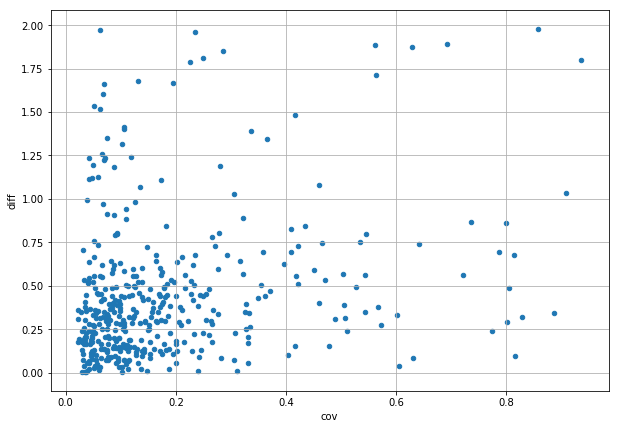

In [14]:
%matplotlib inline
cov_diff[(cov_diff['diff'] < 2) & (cov_diff['cov'] < 1)].plot(x='cov', y='diff', kind='scatter', grid=True, figsize=(10, 7))

In [15]:
cov_diff_1 = cov_diff[(cov_diff['diff'] < 2) & (cov_diff['cov'] < 1)]
cov_diff_1['cov'].corr(cov_diff_1['diff'])

0.26300074957210007

In [16]:
game_logs_test = get_last_n_game_logs(game_stats_logs, 201948, '1300201154', 20)

In [17]:
game_logs_test

,MINS,PTS,AST,OREB,DREB,STL,BLK,TO,FGM,FGA,FG3M
53406,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
53724,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
54168,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
54498,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
55208,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
55535,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
55952,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
56307,2.55,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
57435,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
58355,1.60,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [18]:
get_score_36(game_logs_test)

(1.2846106679467133, 25.612681226349299)

In [ ]:
def get_last_score(game_stats_logs, player_id, game_id):
    

In [20]:
game_stats_logs[(game_stats_logs['PLAYER_ID'] == 201954) & (game_stats_logs['GAME_ID'] == '0021600367')]

,GAME_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_CITY,PLAYER_ID,PLAYER_NAME,START_POSITION,COMMENT,MIN,FGM,...,PF,PTS,PLUS_MINUS,LOCATION,AGAINST_TEAM_ID,GAME_TYPE,GAME_DATE_EST,GAME_SEQUENCE,MINS,GAME_ID_O
158207,0021600367,1610612758,SAC,Sacramento,201954,Darren Collison,G,,31:41,7.0,...,2.0,20.0,25.0,HOME,1610612747,regular_season,2016-12-12T00:00:00,7,31.68,1600200367


In [22]:
player_stats_logs = game_stats_logs[game_stats_logs['PLAYER_ID'] == 201954]

In [23]:
player_stats_logs.sort_values('GAME_ID_O')
player_stats_logs

,GAME_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_CITY,PLAYER_ID,PLAYER_NAME,START_POSITION,COMMENT,MIN,FGM,...,PF,PTS,PLUS_MINUS,LOCATION,AGAINST_TEAM_ID,GAME_TYPE,GAME_DATE_EST,GAME_SEQUENCE,MINS,GAME_ID_O
68,0021200003,1610612742,DAL,Dallas,201954,Darren Collison,G,,32:00,8.0,...,2.0,17.0,0.0,AWAY,1610612747,regular_season,2012-10-30T00:00:00,3,32.00,1200200003
223,0021200009,1610612742,DAL,Dallas,201954,Darren Collison,G,,32:41,6.0,...,2.0,17.0,-3.0,AWAY,1610612762,regular_season,2012-10-31T00:00:00,6,32.68,1200200009
827,0021200034,1610612742,DAL,Dallas,201954,Darren Collison,G,,31:54,8.0,...,2.0,18.0,21.0,HOME,1610612766,regular_season,2012-11-03T00:00:00,8,31.90,1200200034
1137,0021200046,1610612742,DAL,Dallas,201954,Darren Collison,G,,33:40,5.0,...,0.0,14.0,17.0,HOME,1610612757,regular_season,2012-11-05T00:00:00,5,33.67,1200200046
1524,0021200061,1610612742,DAL,Dallas,201954,Darren Collison,G,,35:18,5.0,...,0.0,15.0,-2.0,HOME,1610612761,regular_season,2012-11-07T00:00:00,9,35.30,1200200061
1791,0021200071,1610612742,DAL,Dallas,201954,Darren Collison,G,,30:06,1.0,...,2.0,4.0,-6.0,AWAY,1610612752,regular_season,2012-11-09T00:00:00,4,30.10,1200200071
2103,0021200083,1610612742,DAL,Dallas,201954,Darren Collison,G,,39:10,7.0,...,4.0,14.0,-13.0,AWAY,1610612766,regular_season,2012-11-10T00:00:00,3,39.17,1200200083
2526,0021200100,1610612742,DAL,Dallas,201954,Darren Collison,G,,33:23,5.0,...,2.0,21.0,-14.0,HOME,1610612750,regular_season,2012-11-12T00:00:00,6,33.38,1200200100
2910,0021200115,1610612742,DAL,Dallas,201954,Darren Collison,G,,32:54,2.0,...,0.0,9.0,10.0,HOME,1610612764,regular_season,2012-11-14T00:00:00,7,32.90,1200200115
3127,0021200124,1610612742,DAL,Dallas,201954,Darren Collison,G,,32:07,3.0,...,2.0,10.0,-19.0,AWAY,1610612754,regular_season,2012-11-16T00:00:00,2,32.12,1200200124


In [29]:
player_stats_logs[(player_stats_logs['GAME_ID_O'] < '1600201228') & 
                  (player_stats_logs['MINS'].notnull())].tail(1)

,GAME_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_CITY,PLAYER_ID,PLAYER_NAME,START_POSITION,COMMENT,MIN,FGM,...,PF,PTS,PLUS_MINUS,LOCATION,AGAINST_TEAM_ID,GAME_TYPE,GAME_DATE_EST,GAME_SEQUENCE,MINS,GAME_ID_O
179261,0021601187,1610612758,SAC,Sacramento,201954,Darren Collison,G,,27:59,5.0,...,0.0,15.0,14.0,AWAY,1610612747,regular_season,2017-04-07T00:00:00,9,27.98,1600201187
